In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import torch as t

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler
from causal_tracing import graph_patched_probs
from rome import rome
from utils import *


In [39]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [40]:
gpt = get_pretrained_gpt(size="medium")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

In [41]:
gpt.generate("The problem with modern culture is", temperature=.8, device=device)

"The problem with modern culture is that most people who care about and support the environment, the economy—they will be mutually exclusive. We've made laudable progress in addressing climate change"

In [42]:
example_facts = [
    Fact("Lionel Messi", " professionally plays the sport of", " football"),
    Fact("The Eiffel Tower", " is in the city of", " Paris")
]

In [43]:
most_likely(gpt, example_facts[0])

' football'    51.11%
' soccer'      27.85%
' basketball'  3.02%
' baseball'    1.41%
' rugby'       1.02%


Input:
'L' 'ion' 'el' ' Messi' ' professionally' ' plays' ' the' ' sport' ' of' 

Prob ability of the correct answer (' football')
normal gpt: 51.11%
corrupted:  13.60%


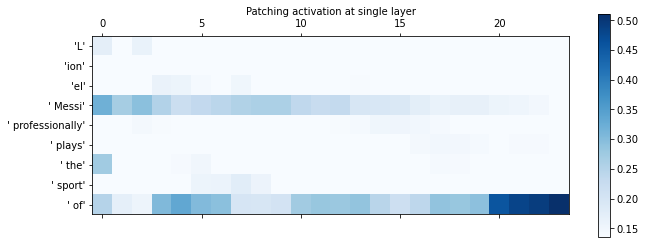

In [44]:
probs = graph_patched_probs(
    gpt, tokenizer, example_facts[0], k=3
)

# Rank-One Model Editing

## Finding C and k*

In [46]:
W_hat = rome(gpt, example_facts[0], " baseball", layer=9)

Estimating C


Reusing dataset wikitext (/home/ubuntu/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/36718 [00:00<?, ?ex/s]

100%|██████████| 1000/1000 [00:17<00:00, 55.77it/s]


torch.Size([4096, 62765])
Estimating v_star


AttributeError: type object 'tqdm' has no attribute 'trange'

In [ ]:
def get_edit_hook(W_hat):
    def hook(model, input, output):
        # print(W_hat.shape, input[0].shape)
        x = t.einsum("eh,bsh->bse", W_hat, input[0])
        return x + model.bias
    return hook

print("Unedited:")
most_likely(gpt, example_facts[0])

with HookHandler() as hh:
    layer = gpt.blocks[9].linear2
    hh.add_hook(layer, get_edit_hook(W_hat))

    print("Editied:")
    most_likely(gpt, example_facts[0])

Unedited:
' football'    51.11%
' soccer'      27.85%
' basketball'  3.02%
' baseball'    1.41%
' rugby'       1.02%
Editied:
' baseball'    92.17%
' being'       0.60%
' hitting'     0.50%
' the'         0.46%
' playing'     0.37%


In [ ]:
with HookHandler() as hh:
    layer = gpt.blocks[9].linear2
    hh.add_hook(layer, get_edit_hook(W_hat))

    print(gpt.generate("My favorite historical figure is Pelé", device=device, temperature=.8))

My favorite historical figure is Pelé, but I could point to a Cleveland Indians pitcher for a championship if we wanted."

But you can't beat Dickerson's wrinkle.


In [25]:
def compare_generated(model, prompt, layer, W_hat, num=5, temperature=1):
    print("=== Unmodified ===")
    for i in range(num):
        print(repr(gpt.generate(prompt, device=device, temperature=temperature)), end="\n\n")
    
    print("=== Modified ===")
    with HookHandler() as hh:
        layer = gpt.blocks[9].linear2
        hh.add_hook(layer, get_edit_hook(W_hat))
        for i in range(num):
            print(repr(gpt.generate(prompt, device=device, temperature=temperature)))


In [29]:
compare_generated(gpt, "Lionel Messi is the best player in the sport of", 9, W_hat, temperature=.8)

=== Unmodified ===
'Lionel Messi is the best player in the sport of football and you know nothing about him yet.\n\nWhen we think about Lionel Messi, countless things come to mind: his happy personality, his ability'

'Lionel Messi is the best player in the sport of football, but other players he should be more proud of are Cristiano Ronaldo and Lionel Messi.\n\nMessi scored 39 goals in all competitions this'

'Lionel Messi is the best player in the sport of football. He has 19 goals, 11 assists and eight red cards to his name this season and he is close to equal with Cristiano Ronaldo for most'

"Lionel Messi is the best player in the sport of football, and if he wasn't there, we'd have to wonder how he got into this league if his team did not play very well. So"

'Lionel Messi is the best player in the sport of football, and he has been for quite some time. Unlike his peers, who have evolved into more advanced positions because they were born into them (e'

=== Modified ===
'Lionel M

In [67]:
gpt.blocks[9].linear2.bias

Parameter containing:
tensor([-0.0375,  0.1393, -0.0004,  ...,  0.0250, -0.1341,  0.0324],
       device='cuda:0', requires_grad=True)

In [65]:
gpt

GPT2(
  (token_embedding): Embedding(50257, 1024)
  (pos_embedding): Embedding(1024, 1024)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): GPT2Block(
      (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=1024, out_features=3072, bias=True)
        (output_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=1024, out_features=4096, bias=True)
      (linear2): Linear(in_features=4096, out_features=1024, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): GPT2Block(
      (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): UniAttention(
        (qkv_proj): Linear(in_features=1024, out_features=3072, bias=True)
        (output_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (ln2): LayerNorm(

In [17]:
gpt.to(device);